# $R_{1\rho}$ Relaxation

In [1]:
#!git clone https://github.com/alsinmr/pyRelaxSim.git
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
sys.path.append('/Users/albertsmith/Documents/GitHub')
import pyRelaxSim as RS
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [2]:
%matplotlib notebook

## Build the system
In this example, we first look at $R_{1\rho}$ relaxation due to reorienation of a dipole coupling and CSA (typical for $^{15}$N)

In [3]:
ex0=RS.ExpSys(v0H=850,Nucs=['15N','1H'],vr=45000)
ex1=ex0.copy()
delta=RS.Tools.dipole_coupling(.102,'1H','15N')
ex0.set_inter('dipole',i0=0,i1=1,delta=delta)
ex0.set_inter('CSA',i=0,delta=150,euler=[0,15*np.pi/180,0])
ex1.set_inter('dipole',i0=0,i1=1,delta=delta,euler=[0,30*np.pi/180,0])
ex1.set_inter('CSA',i=0,delta=150,euler=[[0,15*np.pi/180,0],[0,30*np.pi/180,0]])

## Add the exchange process (symmetric exchange)
First, export this sytem into Liouville space, allowing us to introduce an exchange process. Then we'll define a correlation time and population 1 and population 2. Here we start assuming the populations, $p_1$ and $p_2$ are equal.

In [4]:
L=RS.Liouvillian((ex0,ex1))           #Builds the two different Hamiltonians and exports them to Liouville space

tc=1e-6     #Correlation time (10 s)
p1=0.5  #Population of state 1
p2=1-p1  #Population of state 2

kex=np.array([[-1/(2*tc),1/(2*tc)],[1/(2*tc),-1/(2*tc)]])+\
    np.array([[-(p2-p1)/2,(p1-p2)/2],[(p2-p1)/2,-(p1-p2)/2]])/(tc)
L.kex=kex

## Monitor the decay under a spin-lock
We have to define a sequence to include RF fields. In this case, we'll just take default behavior which is to apply a continuous field for one rotor cycle.

In [5]:
t0=time()
seq=L.Sequence()
seq.add_channel('15N',v1=25000)
U=seq.U()**50    #Take 50 rotor periods at a time (50/45000=1.11 ms)

rho=RS.Rho(rho0='15Nx',detect='15Nx')
_=rho.DetProp(U,n=200)
print(f"Total time was {time()-t0:.1f} s")

Total time was 3.0 s


Plot the results for a simple $R_{1\rho}$ experiment

<IPython.core.display.Javascript object>


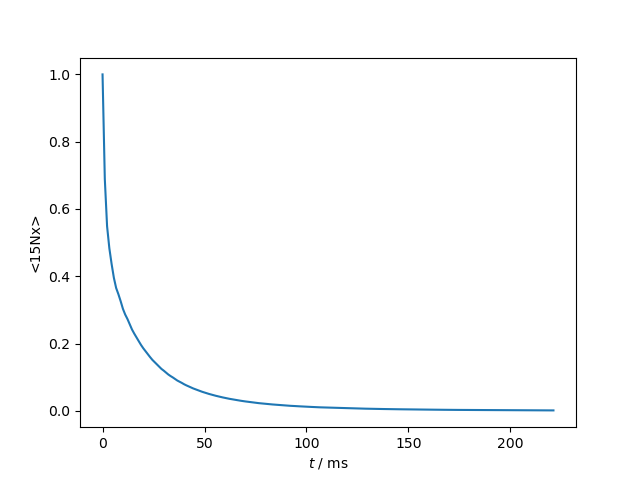

<AxesSubplot:xlabel='$t$ / ms', ylabel='<15Nx>'>

In [6]:
rho.plot()

## Observe behavior as a function of spin-lock strength
We start out with a relatively fast motion, with symmetric exchange

<IPython.core.display.Javascript object>


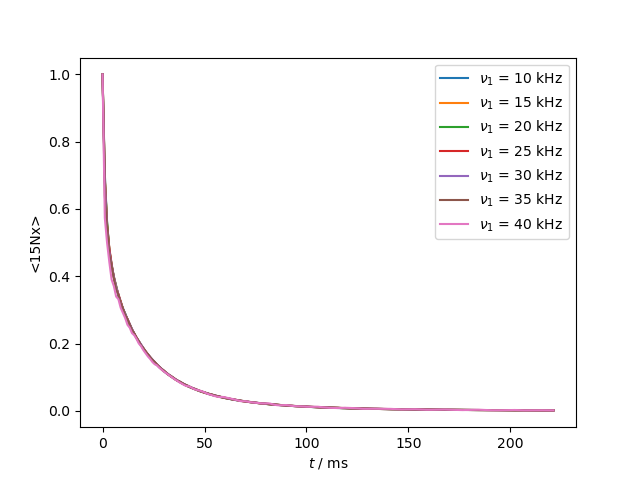

v1=10000, R1p=379.8
v1=15000, R1p=377.5
v1=20000, R1p=373.5
v1=25000, R1p=366.9
v1=30000, R1p=354.6
v1=35000, R1p=328.1
v1=40000, R1p=255.9
Total time was 19.8 s


In [33]:
tc=1e-6     #Correlation time (10 s)
p1=0.5  #Population of state 1
p2=1-p1  #Population of state 2

kex=np.array([[-1/(2*tc),1/(2*tc)],[1/(2*tc),-1/(2*tc)]])+\
    np.array([[-(p2-p1)/2,(p1-p2)/2],[(p2-p1)/2,-(p1-p2)/2]])/(tc)
L.kex=kex

t0=time()
v10=np.linspace(10000,40000,7)  #Every 5 kHz
ax=plt.subplots()[1]
for v1 in v10:
    seq.add_channel('15N',v1=v1)
    U=seq.U()
    rho.clear()
    print(f'v1={v1:.0f}, R1p={rho.extract_decay_rates(U,pwdavg=True):.1f}')
    U=U**50
    rho.DetProp(U,n=200)
    rho.plot(ax=ax)
ax.legend([r'$\nu_1$'+f' = {v1/1e3:.0f} kHz' for v1 in v10])
print(f'Total time was {time()-t0:.1f} s')

## Monitor behavior for slow motion
Now, we replace the exchange rate to see the response to changing $\nu_1$ for slow motion

<IPython.core.display.Javascript object>


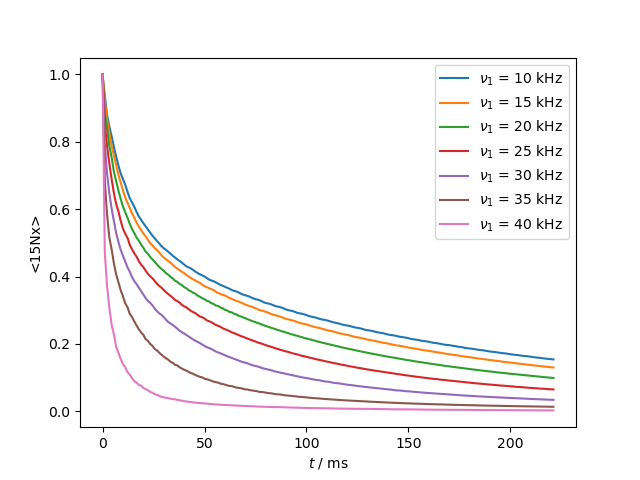

v1=10000, R1p=47.2
v1=15000, R1p=55.7
v1=20000, R1p=70.9
v1=25000, R1p=98.7
v1=30000, R1p=153.3
v1=35000, R1p=275.4
v1=40000, R1p=602.0
Total time was 18.2 s


In [7]:
tc=1e-4     #Correlation time (10 s)
p1=0.5  #Population of state 1
p2=1-p1  #Population of state 2

kex=np.array([[-1/(2*tc),1/(2*tc)],[1/(2*tc),-1/(2*tc)]])+\
    np.array([[-(p2-p1)/2,(p1-p2)/2],[(p2-p1)/2,-(p1-p2)/2]])/(tc)
L.kex=kex

t0=time()
v10=np.linspace(10000,40000,7)  #Every 5 kHz
ax=plt.subplots()[1]
for v1 in v10:
    seq.add_channel('15N',v1=v1)
    U=seq.U()
    rho.clear()
    print(f'v1={v1:.0f}, R1p={rho.extract_decay_rates(U,pwdavg=True):.1f}')
    U=U**50
    rho.DetProp(U,n=200)
    rho.plot(ax=ax)
ax.legend([r'$\nu_1$'+f' = {v1/1e3:.0f} kHz' for v1 in v10])
print(f'Total time was {time()-t0:.1f} s')

We see a relaxation-dispersion effect for the slow motion

## Find $R_{1\rho}$ profiles for various correlation times
Here, we sweep both $\nu_1$ and $\tau_c$. We use a function that extracts the mean relaxation rate constants from rho directly, rather than fitting the decay curves.

In [8]:
t0=time()
tc0=np.logspace(-7,-3,9)
p1=0.5  #Population of state 1
p2=1-p1  #Population of state 2

v10=np.linspace(10000,35000,11)  #Every 2.5 kHz
R1p=np.zeros([tc0.size,v10.size])
for k,tc in enumerate(tc0):
    kex=np.array([[-1/(2*tc),1/(2*tc)],[1/(2*tc),-1/(2*tc)]])+\
        np.array([[-(p2-p1)/2,(p1-p2)/2],[(p2-p1)/2,-(p1-p2)/2]])/(tc)
    L.kex=kex
    
    for m,v1 in enumerate(v10):
        rho.clear()
        seq.add_channel('15N',v1=v1)
        U=seq.U()
        R1p[k,m]=rho.extract_decay_rates(U,pwdavg=True,reweight=True)
        #Decay rate is approximately the loss after one point divided by the time elapsed

print(f'Total time was {time()-t0:.1f} s')

Total time was 275.6 s


Plot the results

<IPython.core.display.Javascript object>


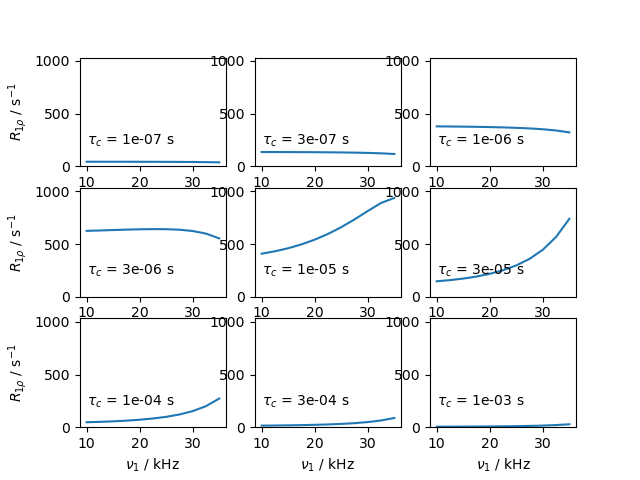

In [11]:
fig,ax=plt.subplots(3,3)
ax=ax.reshape(ax.size)

for R1p0,tc,a in zip(R1p,tc0,ax):
    a.plot(v10/1e3,R1p0)
    if a.get_subplotspec().is_last_row():
        a.set_xlabel(r'$\nu_1$ / kHz')
    if a.get_subplotspec().is_first_col():
        a.set_ylabel(r'$R_{1\rho}$ / s$^{-1}$')
    a.set_ylim([0,R1p.max()*1.1])
    a.text(10,a.get_ylim()[1]*.2,r'$\tau_c$'+f' = {tc:.0e} s')
    

## Inclusion of BMRD (chemical exchange) relaxation
We also add modulation of the chemical shift and re-calculate the above profiles

In [21]:
ex0.set_inter('CS',i=0,ppm=0)  #Add modulation of the chemical shift
ex1.set_inter('CS',i=0,ppm=10)

L=RS.Liouvillian((ex0,ex1))
seq=L.Sequence()

#Re-run the calculation
t0=time()
tc0=np.logspace(-7,-3,9)
p1=0.5  #Population of state 1
p2=1-p1  #Population of state 2

v10=np.concatenate(([2500,5000,7500],np.linspace(10000,35000,11)))  #Every 2.5 kHz
R1p=np.zeros([tc0.size,v10.size])
for k,tc in enumerate(tc0):
    kex=np.array([[-1/(2*tc),1/(2*tc)],[1/(2*tc),-1/(2*tc)]])+\
        np.array([[-(p2-p1)/2,(p1-p2)/2],[(p2-p1)/2,-(p1-p2)/2]])/(tc)
    L.kex=kex
    
    for m,v1 in enumerate(v10):
        rho.clear()
        seq.add_channel('15N',v1=v1)
        U=seq.U()
        R1p[k,m]=rho.extract_decay_rates(U,pwdavg=True,reweight=True)
        #Decay rate is approximately the loss after one point divided by the time elapsed

print(time()-t0)

354.85216999053955


Plot the results

<IPython.core.display.Javascript object>


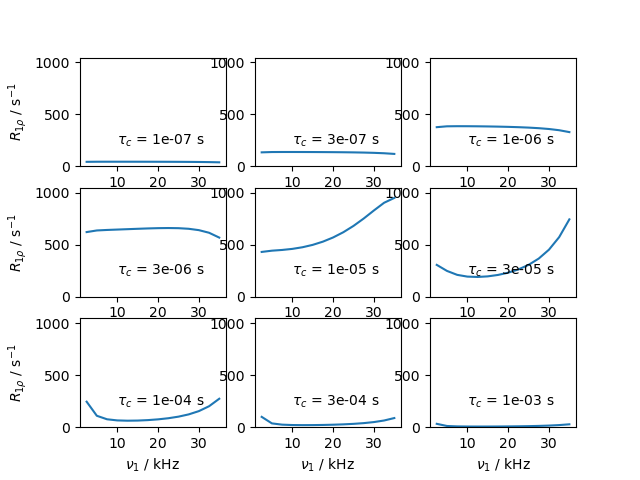

In [22]:
fig,ax=plt.subplots(3,3)
ax=ax.reshape(ax.size)

for R1p0,tc,a in zip(R1p,tc0,ax):
    a.plot(v10/1e3,R1p0)
    if a.get_subplotspec().is_last_row():
        a.set_xlabel(r'$\nu_1$ / kHz')
    if a.get_subplotspec().is_first_col():
        a.set_ylabel(r'$R_{1\rho}$ / s$^{-1}$')
    a.set_ylim([0,R1p.max()*1.1])
    a.text(10,a.get_ylim()[1]*.2,r'$\tau_c$'+f' = {tc:.0e} s')

## Separating population from hop angle/CS change
For fast motion, it is not possible to separate the influence of populations of the two states from amplitudes of motion, or from the change in chemical shift. For example, for NERRD relaxation, relaxation rate constants are proportional to $(1–S^2)$, where $S^2$ is given by

$S^2=1+3p_1p_2(\cos^2(\theta)-1)$

Then, we cannot separate $\theta$ from the populations, $p_1$ and $p_2$. On the other hand, BMRD relaxation is proportional to

$p_1p_2(\Delta\Omega)^2$

which similarly does not allow us to separate the populations. For example, consider two systems with the same values for $S^2$ and for $p_1p_2(\Delta\Omega)^2$

In [7]:
hop_angle=40
DeltaCS=0
tc=3e-5     #Correlation time (10 s)
p1=0.5  #Population of state 1
p2=1-p1  #Population of state 2
S2=3*p1*p2*(np.cos(hop_angle*np.pi/180)**2-1)+1
p1p2DelCS2=p1*p2*DeltaCS
print(f'S2 for system 1 is {S2:.3f}')
print(f'p1*p2*Delta(CS) for system 1 is {p1p2DelCS2:.3f}')

ex0=RS.ExpSys(v0H=850,Nucs=['15N','1H'],vr=45000)
ex1=ex0.copy()
delta=RS.Tools.dipole_coupling(.102,'1H','15N')
ex0.set_inter('dipole',i0=0,i1=1,delta=delta)
ex0.set_inter('CSA',i=0,delta=150,euler=[0,15*np.pi/180,0])
ex0.set_inter('CS',i=0,ppm=0)
ex1.set_inter('dipole',i0=0,i1=1,delta=delta,euler=[0,hop_angle*np.pi/180,0])
ex1.set_inter('CSA',i=0,delta=150,euler=[[0,15*np.pi/180,0],[0,hop_angle*np.pi/180,0]])
ex1.set_inter('CS',i=0,ppm=DeltaCS)

L1=RS.Liouvillian((ex0,ex1))           #Builds the two different Hamiltonians and exports them to Liouville space

kex=1/(2*tc)*(np.array([[-1,1],[1,-1]])+(p1-p2)*np.array([[1,1],[-1,-1]]))

L1.kex=kex
d,v=np.linalg.eig(kex)
print(f'tc for system 1 is {-1/d.min():.1e} s\n')

p1=0.75  #Population of state 1
p2=1-p1  #Population of state 2
hop_angle=np.arccos(np.sqrt((S2-1)/(3*p1*p2)+1))*180/np.pi
DeltaCS=p1p2DelCS2/(p1*p2)

S2=3*p1*p2*(np.cos(hop_angle*np.pi/180)**2-1)+1
p1p2DelCS2=p1*p2*DeltaCS
print(f'S2 for system 2 is {S2:.3f}')
print(f'p1*p2*Delta(CS) for system 2 is {p1p2DelCS2:.3f}')


ex0=RS.ExpSys(v0H=850,Nucs=['15N','1H'],vr=45000)
ex1=ex0.copy()
delta=RS.Tools.dipole_coupling(.102,'1H','15N')
ex0.set_inter('dipole',i0=0,i1=1,delta=delta)
ex0.set_inter('CSA',i=0,delta=150,euler=[0,15*np.pi/180,0])
ex0.set_inter('CS',i=0,ppm=0)
ex1.set_inter('dipole',i0=0,i1=1,delta=delta,euler=[0,hop_angle*np.pi/180,0])
ex1.set_inter('CSA',i=0,delta=150,euler=[[0,15*np.pi/180,0],[0,hop_angle*np.pi/180,0]])
ex1.set_inter('CS',i=0,ppm=DeltaCS)

L2=RS.Liouvillian((ex0,ex1))           #Builds the two different Hamiltonians and exports them to Liouville space

kex=np.array([[-1/(2*tc),1/(2*tc)],[1/(2*tc),-1/(2*tc)]])+\
    np.array([[-(p2-p1)/2,(p1-p2)/2],[(p2-p1)/2,-(p1-p2)/2]])/(tc)
L2.kex=kex

print(f'tc for system 2 is {-1/d.min():.1e} s')

S2 for system 1 is 0.690
p1*p2*Delta(CS) for system 1 is 0.000
tc for system 1 is 3.0e-05 s

S2 for system 2 is 0.690
p1*p2*Delta(CS) for system 2 is 0.000
tc for system 2 is 3.0e-05 s


<IPython.core.display.Javascript object>


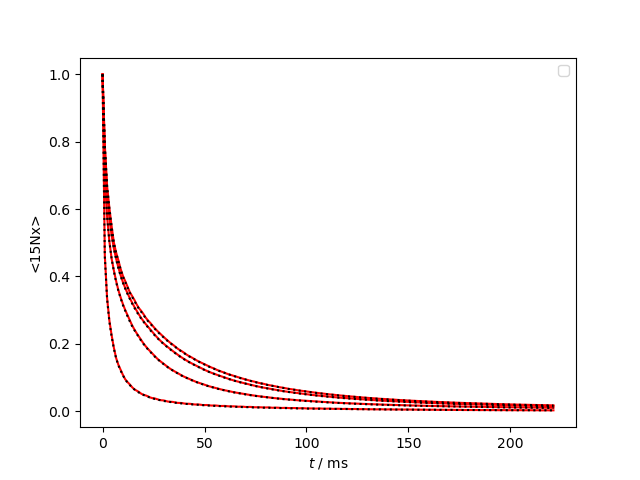

v1=2500, R1p=226.0
v1=10000, R1p=254.2
v1=20000, R1p=375.6
v1=35000, R1p=1265.2
Total time was 10.0 s
v1=2500, R1p=315.4
v1=10000, R1p=353.3
v1=20000, R1p=515.6
v1=35000, R1p=1670.1
Total time was 10.6 s


In [9]:
v10=[2500,10000,20000,35000]
ax=plt.subplots()[1]
for L,ls,clr in zip([L1,L2],['-',':'],['red','black']):
    seq=L.Sequence()
    t0=time()
    
    for v1 in v10:
        seq.add_channel('15N',v1=v1)
        U=seq.U()
        rho.clear()
        print(f'v1={v1:.0f}, R1p={rho.extract_decay_rates(U,pwdavg=True):.1f}')
        U=U**50
        rho.DetProp(U,n=200)
        rho.plot(ax=ax,linestyle=ls,color=clr)
#    ax.legend([r'$\nu_1$'+f' = {v1/1e3:.0f} kHz' for v1 in v10])
    print(f'Total time was {time()-t0:.1f} s')